In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
sys.path.append("/home/wanghaifeng/whf_work/work_sync/models_seg")
sys.path.append("/home/wanghaifeng/whf_work/work_sync/satellite_data/models_config/GeoSeg")
sys.path.append('/home/wanghaifeng/whf_work/work_sync/satellite_data/models_config/segment-anything/segment_anything')
sys.path.append("/home/wanghaifeng/whf_work/work_sync/satellite_data/models_config/mmpretrain")
import matplotlib.pyplot as plt
import json
import sys
from torch  import nn
from tqdm import tqdm
from torch import optim
import torch.nn.functional as F
import cv2
import numpy as np
import math
from glob import glob
from os.path import join
import torch
from torch.nn import functional as F
from init import *
from train_model import train_model
from lossers import dice_loss
# from  models import get_model
from lossers import get_loss_function
from vdatasets import get_dataloader
from optimizers_schedulers import get_optimizer_scheduler, update_paramter
from utiles.mask_utles import get_color_mask,mask2color,show_image_mask,show_image_mask_, rgbmask2label,label_colormap, image_diff
from utiles.mask_utles import rgbmask2label,label2rgbmask,rgb2cls_masks,label2rgbmask2,label_colormap
from utiles.tensor2imgmask import *
from models import get_model,model_dic
from get_models import model_dic_geoseg,model_dic_mmseg
model_dic.update(model_dic_geoseg)
model_dic.update(model_dic_mmseg)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

['base_unet', 'vgg_unet', 'vgg_unet1', 'FDD_3_3', 'FDD_model_3_3_2', 'FDD_model_multitask', 'FDD_model_5_3', 'vit_model', 'vit_model_5_3', 'cbrnet', 'cbrnetmc', 'ABCNet', 'A2FPN', 'BANet', 'MANet', 'FTUNetFormer', 'UNetFormer']


In [144]:
##1. 数据配置
config_path = './model_works/vgg_unet/vgg_unet_2024_02_28_23_50_19/model_config.json'
cfg = json.load(open(config_path))
# cfg['model']='base_unet'
cfg['model_param']={"n_channels":3,'n_classes':3}
# # cfg['data']['dataset']='segmuilt_dataset'
# # # cfg['data']['use_cls']=['buildings','damaged_buildings']
# cfg['data']['use_sub']=['images','masks','images_sr']
# cfg['data']['catsubf']=['images','images_sr']
# # cfg['data']['path']=r'/home/wanghaifeng/project_work/datasets/flood_dataset_competition/Track2/Track2'
# cfg['data']['n_classes']=3
cfg['training']['batch_size']=1
# cfg['training']['img_size']=(256,256)
# cfg['training']['loss']['mask_key']=['masks']

n_classes=cfg['data']['n_classes']
load_weights =config_path.replace('model_config.json','model_best.pt').replace('.json','.pt')
model_not_dataparal = False

if not Path(load_weights).exists():
        load_weights=''


model = model_dic[cfg['model']](**cfg['model_param'])

if model_not_dataparal:
    model.load_state_dict(torch.load(load_weights, map_location='cpu'))
    load_weights = ''
    
model = torch.nn.parallel.DataParallel(model)
if len(load_weights)>0:
    print('loading weights',load_weights)
    model.load_state_dict(torch.load(load_weights, map_location='cpu'))

optimizer, scheduler = get_optimizer_scheduler(model,cfg)

get_train_loss_func = get_loss_function(cfg["training"]["loss"].copy())

trainloader, valloader = get_dataloader(cfg)
# testloader = get_dataloader(cfg,model='testing')

loading weights ./model_works/vgg_unet/vgg_unet_2024_02_28_23_50_19/model_best.pt
init optimizer : rmsprop params:  {'lr': 0.001, 'weight_decay': 1e-05, 'momentum': 0.9}
init scheduler:  steplr params:  {'step_size': 1, 'gamma': 0.7}
init loss : loss_cross_entropy_mutliclas  params: {'mask_key': ['mask_pre_1']}
init dataset:  mapdataset
----------------------- /home/wanghaifeng/project_work/datasets/data_workspaces/labeled_data_test
data config:  {'seed': 1337, 'model': 'vgg_unet', 'model_param': {'n_channels': 3, 'n_classes': 3}, 'data': {'dataset': 'mapdataset', 'n_classes': 3, 'use_ori_size': True, 'use_cls': ['buildings', 'damaged_buildings'], 'path': '/home/wanghaifeng/project_work/datasets/data_workspaces/labeled_data_test', 'split': '', 'data_img_size': [1024, 1024], 'use_sub': ['mask_pre_1', 'mask_pre_2', 'mask_pre_3'], 'index': 'image', 'limt_num': None, 'used_datainfo': False}, 'training': {'batch_size': 1, 'n_workers': 4, 'end_epoch': 20, 'img_size': [1024, 1024], 'optimizer

In [230]:
import torchvision.transforms.functional as transF
mask_key = cfg['training']['loss']['mask_key']
for i,data in enumerate(trainloader):   
   
    img = data[list(data.keys())[0]]
    image_t1   = torch.nn.functional.normalize(img.cuda().float())
    with torch.no_grad():
        rs = model(image_t1)
    
#     f_p = data['paths'][0]
#     r1 = rs[0].detach().cpu().numpy()
#     r2 = torch.argmax(rs,1)
#     label = r2.detach().cpu().numpy()[0]
#     label[label>1]=1
#     cv2.imwrite(f_p.replace('images','labels_preO').replace('.tif','.png'),label)
    
#     label = cv2.resize(np.array(label,np.uint8),(128,128))
#     cv2.imwrite(f_p.replace('images','masks_pre').replace('.tif','.png'),label)
    
    if i>5:
        print(i)
        break
    break

In [231]:
# for i,data in enumerate(testloader):   
#     img = data[list(data.keys())[0]]
#     image_t1   = torch.nn.functional.normalize(img.cuda().float())
#     w,h = image_t1.shape[-2:]
#     wn,hn = int(w/320),int((h/320))
#     dw,dh = int(w/wn), int(h/hn)
#     maks_s = torch.zeros(image_t1.shape)
#     for w1 in range(wn):
#         for h1 in range(hn):
#             sub_img = image_t1[:,:,w1*dw:(w1+1)*dw,h1*dh:(h1+1)*dh]
#             sub_img0 = img[:,:,w1*dw:(w1+1)*dw,h1*dh:(h1+1)*dh]
#             sub_img = F.interpolate(sub_img, mode='bilinear', size=image_t1.shape[-2:])
#             # sub_img0 = F.interpolate(sub_img0, mode='bilinear', size=image_t1.shape[-2:])
#             with torch.no_grad():
#                 rs = model(sub_img)
#             rs = F.interpolate(rs, mode='bilinear', size=(dw,dh))
#             maks_s[:,:,w1*dw:(w1+1)*dw,h1*dh:(h1+1)*dh]=rs 

In [232]:
# img = cv2.imread('/home/wanghaifeng/project_work/datasets/test/images/002.png')
# img = cv2.resize(img,(512,512))
# img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
# img = torch.from_numpy(img.transpose(2,0,1))
# img = img.unsqueeze(0)

# image_t1   = torch.nn.functional.normalize(img.cuda().float())
# with torch.no_grad():
#     rs = model(image_t1)

In [233]:
img0 = img.cpu().numpy()
img0=img0[0].transpose(1,2,0)
img1 = img0[:,:,:]
img1 = img1/img1.max()

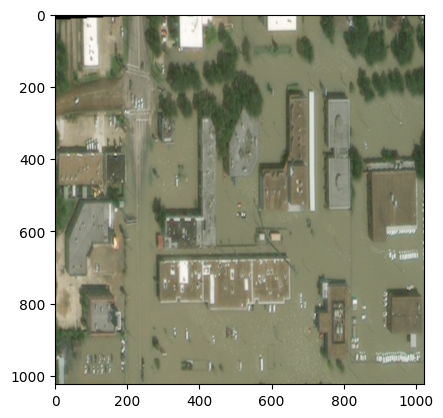

In [234]:
plt.imshow(img1)

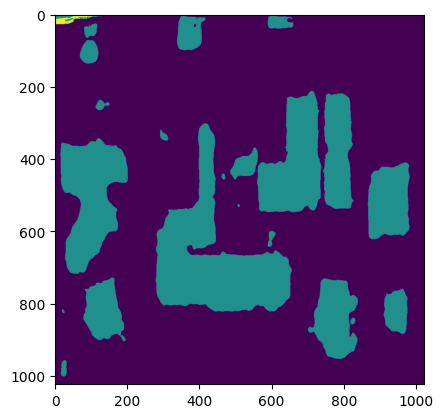

In [258]:
if type(rs)==tuple or type(rs)==list:
    rs = rs[0]
r2 = torch.argmax(rs,1)
label_pre = r2.detach().cpu().numpy()
plt.imshow(label_pre[0])

In [259]:
label_pre = cv2.cvtColor(np.array(label_pre[0]*255,np.uint8),cv2.COLOR_GRAY2BGR)

kernel = np.ones((3,3), np.uint8)  
dilated_img = cv2.erode(label_pre, kernel, iterations =8)
# # # 进行膨胀操作  
# kernel = np.ones((3,3), np.uint8)  
dilated_img = cv2.dilate(dilated_img , kernel, iterations = 18) 
kernel = np.ones((3,3), np.uint8)  
label_pre = cv2.erode(dilated_img, kernel, iterations = 8)

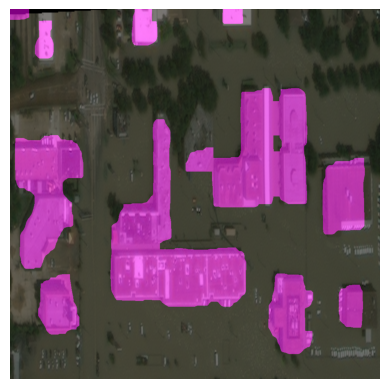

In [260]:
    mask_gray = label_pre[:,:,0]
    img = cv2.resize(img1,mask_gray.shape[:2])
    n=0.5
    mask_img = np.zeros((mask_gray.shape[0],mask_gray.shape[1],4),np.uint8)
    mask_img[mask_gray>0] = [255,0,255,130]
    mask_img[mask_gray==2] = [255,0,255,130]
    # mask_img[:,:,-1] = int(255*0.5)
    mask_img[:,:,-1]=130
    plt.imshow(img)
    plt.imshow(mask_img)
    plt.axis('off')
    plt.savefig('test22.png' ,bbox_inches='tight',pad_inches=0.0)

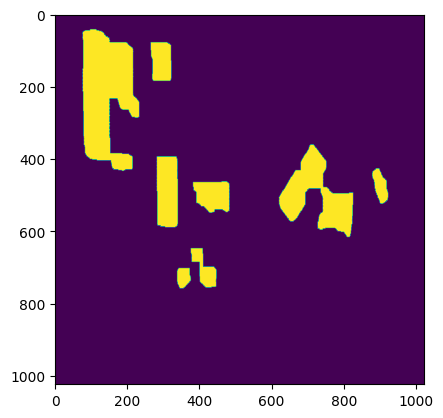

In [21]:
plt.imshow(data[mask_key[0]][0,0])

(-0.5, 1023.5, 1023.5, -0.5)

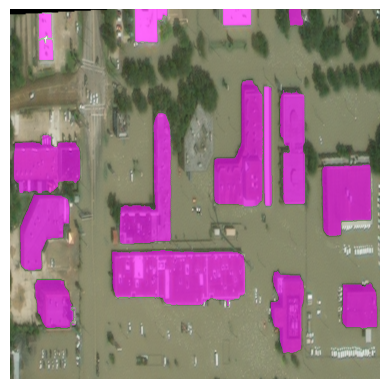

In [21]:
    mask_gray = data[mask_key[0]][0,0].numpy()
    img = cv2.resize(img1,mask_gray.shape[:2])
    n=0.5
    mask_img = np.zeros((mask_gray.shape[0],mask_gray.shape[1],4),np.uint8)
    mask_img[mask_gray==1] = [0,255,0,150]
    mask_img[mask_gray==2] = [255,0,255,150]
    # mask_img[:,:,-1] = int(255*0.5)
    plt.imshow(img)
    plt.imshow(mask_img)
    plt.axis('off')